In [20]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [21]:
G = nx.karate_club_graph()
pos = nx.spring_layout(G, seed=4)

colors = [
    "tab:blue","tab:orange","tab:green","tab:red","tab:purple",
    "tab:brown","tab:pink","tab:gray","tab:olive","tab:cyan",
    "yellow","magenta","black","white"
]

In [22]:
def try_split(Gsub):
    # adjacency matrix (as numpy array)
    nodes = list(Gsub)
    A = nx.to_numpy_array(Gsub, nodelist=nodes)

    # degree vector (row) and modularity matrix
    k = np.array([d for _, d in Gsub.degree()], dtype=float)[np.newaxis, :]
    m = float(Gsub.number_of_edges())
    B = A - (k.T @ k) / (2.0 * m)

    # eigen-stuff
    evals, evecs = np.linalg.eigh(B)
    i = int(np.argmax(evals))

    if evals[i] <= 0:
        return [], []   # nothing good to split

    vec = evecs[:, i]

    # split by sign of the eigenvector
    left = []
    right = []
    for idx, val in enumerate(vec):
        if val > 0:
            left.append(nodes[idx])
        else:
            right.append(nodes[idx])
    return left, right

In [23]:
def draw_communities(Gfull, pos, communities, step_num):
    color_for_node = {}
    for idx, comm in enumerate(communities):
        for u in comm:
            color_for_node[u] = colors[idx % len(colors)]

    node_colors = []
    for n in Gfull.nodes():
        node_colors.append(color_for_node.get(n, "tab:blue"))

    plt.figure(figsize=(9, 6))
    nx.draw(
        Gfull, pos,
        node_color=node_colors,
        with_labels=True,
        node_size=500,
        edgecolors="black",
        linewidths=0.8
    )
    plt.title(f"After split #{step_num}  |  communities: {len(communities)}")
    plt.axis("off")
    plt.show(block=True)
    plt.close()

In [24]:
def make_empty_history(Gfull):
    history = {
        "degree": {},
        "betweenness": {},
        "closeness": {},
        "clustering": {}
    }
    for n in Gfull.nodes():
        history["degree"][n] = []
        history["betweenness"][n] = []
        history["closeness"][n] = []
        history["clustering"][n] = []
    return history

def record_step_metrics(Gfull, communities, history):
    # start with zeros so every node gets a number at this step
    deg_all = {n: 0.0 for n in Gfull.nodes()}
    bet_all = {n: 0.0 for n in Gfull.nodes()}
    clo_all = {n: 0.0 for n in Gfull.nodes()}
    clu_all = {n: 0.0 for n in Gfull.nodes()}

    for comm in communities:
        H = Gfull.subgraph(comm)
        if len(H) > 1:
            deg = nx.degree_centrality(H)
            bet = nx.betweenness_centrality(H, normalized=True)
            clo = nx.closeness_centrality(H)
            clu = nx.clustering(H)
            for u in H.nodes():
                deg_all[u] = deg[u]
                bet_all[u] = bet[u]
                clo_all[u] = clo[u]
                clu_all[u] = clu[u]

    # append to history lists
    for n in Gfull.nodes():
        history["degree"][n].append(deg_all[n])
        history["betweenness"][n].append(bet_all[n])
        history["closeness"][n].append(clo_all[n])
        history["clustering"][n].append(clu_all[n])

In [25]:
def split_show_record(Gsub, Gfull, pos, communities, history, step_box):
    left, right = try_split(Gsub)
    if len(left) == 0 or len(right) == 0:
        return  # can't split this part

    # find which community equals nodes(Gsub) and replace it with the two children
    target = set(Gsub.nodes())
    for i in range(len(communities)):
        if communities[i] == target:
            communities.pop(i)
            communities.append(set(left))
            communities.append(set(right))
            break

    # one more step done
    step_box[0] += 1
    record_step_metrics(Gfull, communities, history)
    draw_communities(Gfull, pos, communities, step_box[0])

    # now recurse on the two new pieces
    split_show_record(Gfull.subgraph(left),  Gfull, pos, communities, history, step_box)
    split_show_record(Gfull.subgraph(right), Gfull, pos, communities, history, step_box)

In [26]:
def print_communities(communities):
    print("\nFinal communities:")
    for i, comm in enumerate(communities, start=1):
        print("  Community", i, "(", len(comm), "):", sorted(list(comm)))

In [27]:
def show_node_bar(Gfull, pos, communities, node):
    # color the graph
    color_for_node = {}
    for idx, comm in enumerate(communities):
        for u in comm:
            color_for_node[u] = colors[idx % len(colors)]
    node_colors = [color_for_node.get(n, "tab:blue") for n in Gfull.nodes()]

    # simple metrics on the full graph
    deg = nx.degree_centrality(Gfull)[node]
    bet = nx.betweenness_centrality(Gfull, normalized=True)[node]
    clo = nx.closeness_centrality(Gfull)[node]
    clu = nx.clustering(Gfull)[node]

    labels = ["degree", "betweenness", "closeness", "clustering"]
    values = [deg, bet, clo, clu]

    # which community is this node in
    comm_id = None
    for i, c in enumerate(communities, start=1):
        if node in c:
            comm_id = i
            break

    # make the figure
    fig = plt.figure(figsize=(12, 5))
    gs = fig.add_gridspec(1, 2, width_ratios=[3, 1], wspace=0.3)

    ax0 = fig.add_subplot(gs[0, 0])
    nx.draw(Gfull, pos, node_color=node_colors, with_labels=True, ax=ax0,
            node_size=500, edgecolors="black", linewidths=0.8)
    nx.draw_networkx_nodes(Gfull, pos, nodelist=[node], ax=ax0,
                           node_color="white", edgecolors="black",
                           linewidths=2.5, node_size=900)
    ax0.set_title(f"Selected node: {node}  |  Community #{comm_id}")
    ax0.axis("off")

    ax1 = fig.add_subplot(gs[0, 1])
    ax1.bar(labels, values)
    ax1.set_xticks(range(len(labels)))
    ax1.set_xticklabels(labels, rotation=25, ha="right")
    top = max(values) if len(values) > 0 else 1
    ax1.set_ylim(0, top * 1.25)
    for i, v in enumerate(values):
        ax1.text(i, v + top * 0.03, f"{v:.3f}", ha="center", va="bottom", fontsize=9)
    ax1.set_title("Node metrics (full graph)")

    plt.tight_layout()
    plt.show(block=True)
    plt.close()

def plot_node_history(history, node):
    # get this node's lists over steps
    deg = history["degree"][node]
    bet = history["betweenness"][node]
    clo = history["closeness"][node]
    clu = history["clustering"][node]
    steps = list(range(len(deg)))

    plt.figure(figsize=(9, 6))
    plt.plot(steps, deg, marker="o", linewidth=2, label="degree")
    plt.plot(steps, bet, marker="o", linewidth=2, label="betweenness")
    plt.plot(steps, clo, marker="o", linewidth=2, label="closeness")
    plt.plot(steps, clu, marker="o", linewidth=2, label="clustering")
    plt.xticks(steps)
    plt.xlabel("split # (after step)")
    plt.ylabel("value")
    plt.title(f"Metric evolution for node {node} (inside its community)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show(block=True)
    plt.close()

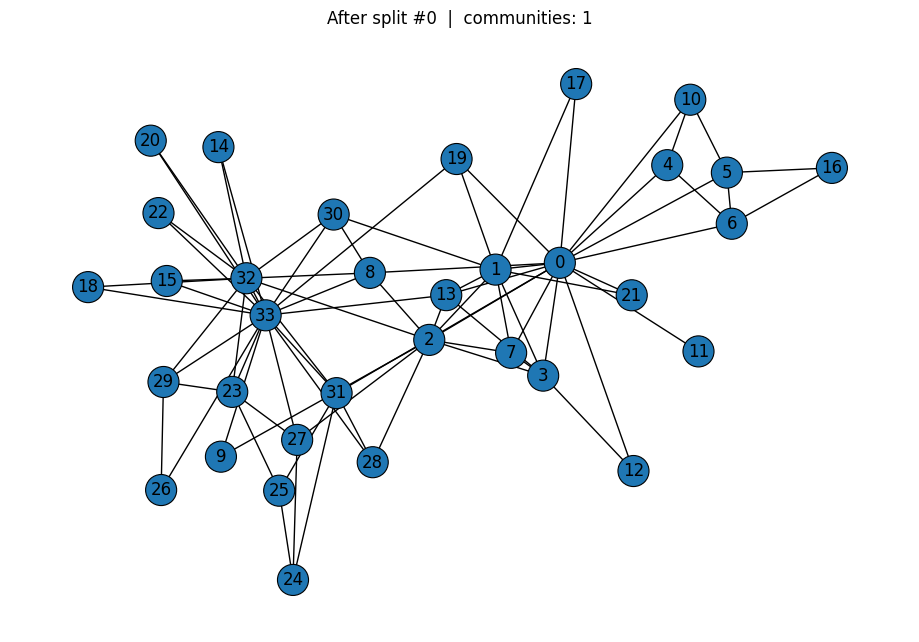

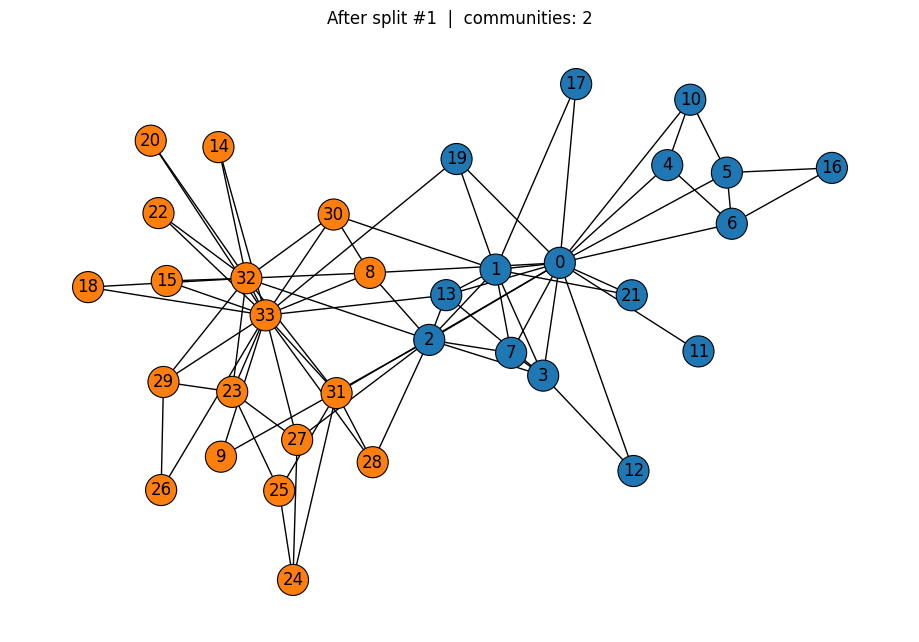

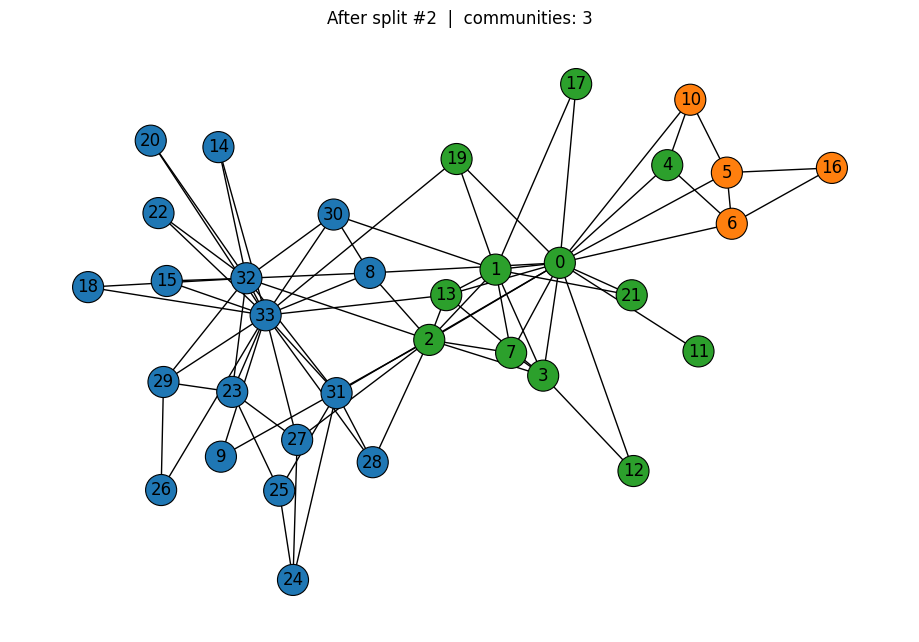


Final communities:
  Community 1 ( 18 ): [8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
  Community 2 ( 4 ): [5, 6, 10, 16]
  Community 3 ( 12 ): [0, 1, 2, 3, 4, 7, 11, 12, 13, 17, 19, 21]

Type a node id (0–33) to view metrics and evolution. Type 'q' to quit.

Node id (or 'q'): 4


/tmp/ipython-input-1741552348.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


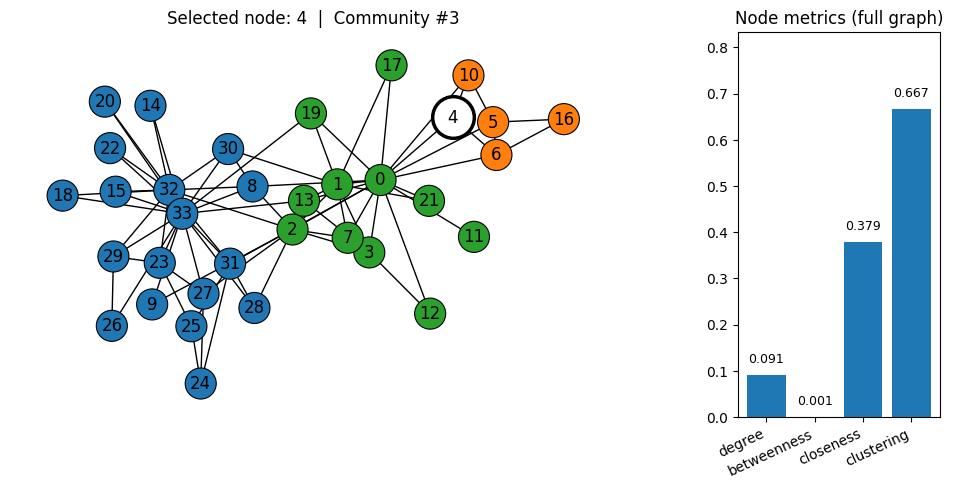

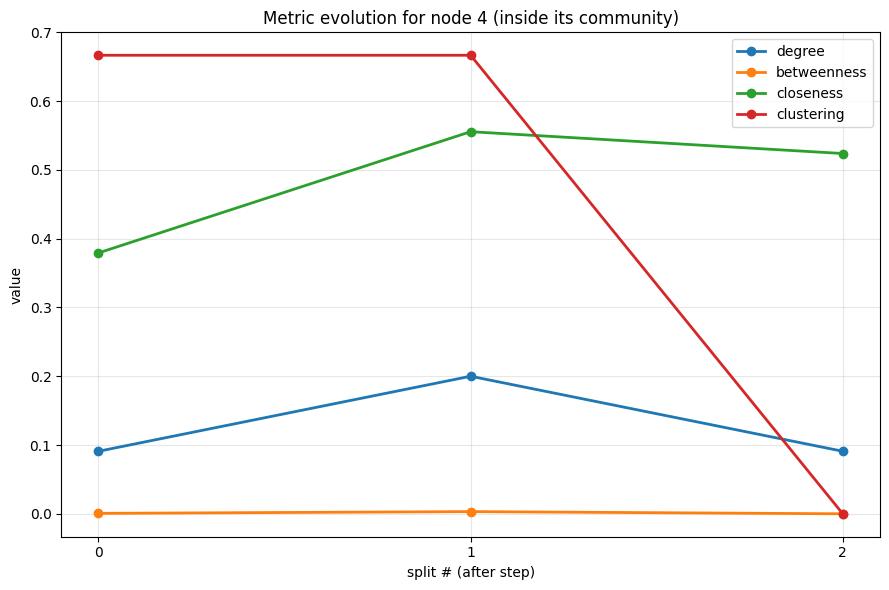

Node id (or 'q'): 0


/tmp/ipython-input-1741552348.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


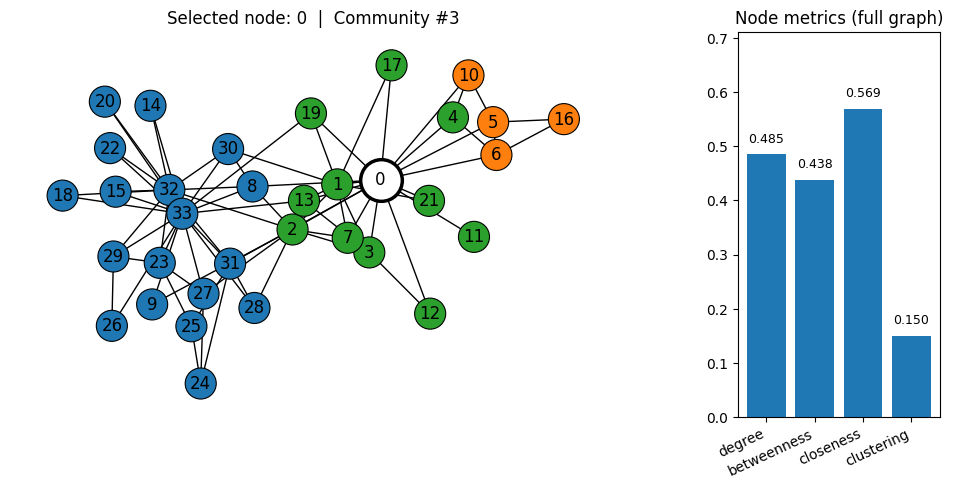

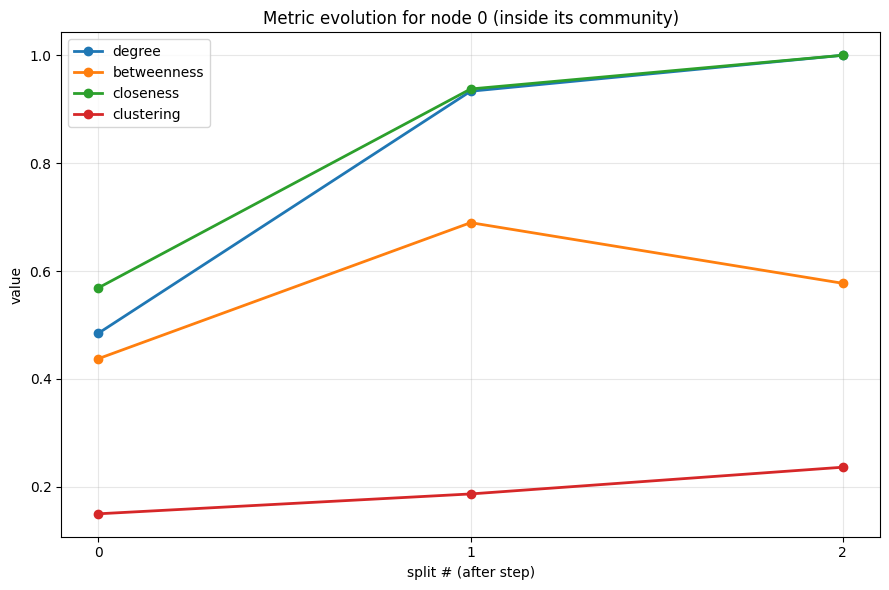

Node id (or 'q'): q
Bye!


In [28]:
communities = [set(G.nodes())]     # start with one big community
history = make_empty_history(G)

# step 0: before any splits
record_step_metrics(G, communities, history)
draw_communities(G, pos, communities, step_num=0)

# do the recursive splitting (shows a picture after each split)
step_box = [0]   # small trick so we can modify the counter inside recursion
split_show_record(G, G, pos, communities, history, step_box)

# show the final list of communities
print_communities(communities)

# interactive loop for node queries
print("\nType a node id (0–33) to view metrics and evolution. Type 'q' to quit.\n")
while True:
    try:
        s = input("Node id (or 'q'): ").strip()
    except (EOFError, KeyboardInterrupt):
        print("\nBye!")
        break

    if s.lower() in ["q", "quit", "exit"]:
        print("Bye!")
        break

    if not s.isdigit():
        print("Please enter an integer node id, or 'q' to quit.")
        continue

    node = int(s)
    if node not in G.nodes():
        print("That node is not in the graph. Try again.")
        continue

    show_node_bar(G, pos, communities, node)
    plot_node_history(history, node)